In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable
from progressbar import ProgressBar

%run ../functions/preprocessing_functions.py ./
%run ../functions/color_functions.py ./
%run ../functions/time_series.py ./

# load world maps as background
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop([159,22,23],inplace=True) # Antarctica, Greenland,Seven seas (tiny islands Indian ocean)

Basin shapes have been downloaded from the [GRDC website](https://www.bafg.de/GRDC/EN/02_srvcs/22_gslrs/221_MRB/riverbasins_2020.html?nn=201570#doc2731742bodyText2). The following table contains all basins with an area larger than $65,000 \ km^2$. It additionally indicates the continent where the basin is located, the ocean where water is discharged (if applicable), the basin discharge area, the main climate zone (with full names and abbreviations following the [Koppen-Geiger classification](http://worldmap.harvard.edu/data/geonode:koppen_geiger_climate_classification_rev_g21)), the area covered by the main climate zone, and the cluster determined by the hierarchical algorithm (see the dendrogram in the article). 

In [2]:
basins=geopandas.read_file('../data/basins/basins.shp').set_index('name')
basins.head()

,continent,ocean,area,climate,clim area,cluster,clim name,geometry
name,,,,,,,,
WINISK,"North America, Central America and the Caribbean",Arctic Ocean,65635.3,Dfc,99.743367,other,Snow fully humid cool summer,"POLYGON ((-87.24167 52.32500, -87.24223 52.314..."
COPPER,"North America, Central America and the Caribbean",Pacific Ocean,65704.3,Dfc,56.077317,other,Snow fully humid cool summer,"POLYGON ((-140.15833 61.00000, -140.15890 60.9..."
NOTTAWAY,"North America, Central America and the Caribbean",Arctic Ocean,66053.1,Dfc,96.210946,other,Snow fully humid cool summer,"MULTIPOLYGON (((-73.85417 50.00833, -73.85089 ..."
TALAS,Asia,---,66179.8,BSk,65.765573,other,Arid Steppe cold,"POLYGON ((73.61250 42.33333, 73.60612 42.33277..."
MARONI,South America,Atlantic Ocean,66408.4,Afm,92.235931,other,Equatorial rainforest/monsoon,"POLYGON ((-53.08750 3.20833, -53.08508 3.20798..."


# 1. Explore one basin and one dataset

Datasets are saved on a $0.5° \times 0.5°$ grid with monthly time steps in the folder `data/hydrology`. The function `get_hydro_data` transforms netCDF files to dataframe with one month per column and one grid point per row.

- For precipitation (`'P'`) choose among : `'CPC'`, `'CRU'`, `'GPCC'`, `'GPCP'`, `'GPM'`, `'TRMM'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'GLDAS20'` (PGF), `'MSWEP'`

- For evapotranspiration (`'ET'`) choose among : `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GLDAS22_CLSM25'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'SSEBop'`, `'GLEAM'`, `'MOD16'`, `'FLUXCOM'`

- For runoff (`'R'`) choose among `'GLDAS20_NOAH36'`, `'GLDAS20_CLSM25'`, `'GLDAS20_VIC412'`, `'GLDAS21_NOAH36'`, `'GLDAS21_CLSM25'`, `'GLDAS21_VIC412'`, `'GLDAS22_CLSM25'`, `'ERA5_Land'`, `'MERRA2'`, `'JRA55'`, `'GRUN'`

- For water storage (`'TWS'`) choose among `'GRACE_JPL_mascons'`, `'GRACE_CSR_mascons'`

In [3]:
hydro_var_name='P' # 'P', 'ET', 'R', or 'TWS'
dataset='CPC'

hydro_grid,time_hydro=get_hydro_data(hydro_var_name,dataset)

For a given month, plot the value at each grid point.

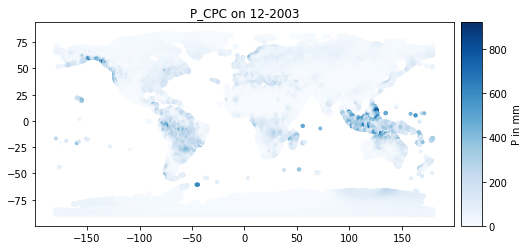

In [4]:
month=12
year=2003

norm,cmap=define_cmap(hydro_var_name,hydro_grid[date(year,month,1)].values)

fig, ax = plt.subplots(figsize=(8,5))
ax.set_aspect('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='black')
hydro_grid.plot(ax=ax,marker='.',column=date(year,month,1),
             legend=True,legend_kwds={'label': "{} in mm".format(hydro_var_name)},cax=cax,
            cmap=cmap,norm=norm)

ax.set_title('{}_{} on {}-{}'.format(hydro_var_name,dataset,month,year))
plt.show()

### Build the time-series inside a selected basin

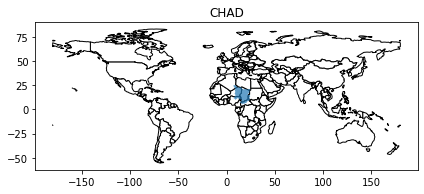

In [5]:
basin_name='CHAD'

fig, ax = plt.subplots()
ax.set_aspect('equal')
world.plot(ax=ax, color='white', edgecolor='black')
basins.loc[[basin_name],'geometry'].plot(ax=ax, alpha=0.7)
plt.title(basin_name)
plt.tight_layout()
plt.show()

To find the grid coordinates located inside a given basin, we rely on R-trees (__[reference](https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html)__). The method is the following : 

1. we compare the bounds of the Polygon into the spatial index of the Points. This gives us point candidates that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree). 

1. we go through the candidate points and make a normal spatial intersection query that gives us the accurate results

To limit the computational cost, the indices of each basin have been saved and they are retrieved in the followng cell.

In [6]:
basin_indices=geopandas.read_file("../data/basins/{}.shp".format(basin_name))
basin_indices.set_index(pd.MultiIndex.from_frame(basin_indices[['x','y']]),inplace=True)
hydro_grid.set_index(pd.MultiIndex.from_frame(hydro_grid[['x','y']]),inplace=True)

# select only grid points in basin_indices
hydro_basin=basin_indices.join(hydro_grid.loc[:,[d.date() for d in time_hydro]])
hydro_basin.set_index(np.arange(hydro_basin.shape[0]),inplace=True)

Gridded values are summed over all basin points while taking into account the area of each grid cell. The same function also returns the filtered variable used to match the derivation of TWS into TWSC [[Landerer 2010]](http://doi.wiley.com/10.1029/2010JD014584). If we are examining TWS, the derivative TWSC is returned instead.

In [7]:
mean_ts,filter_ts=get_hydro_timeseries(hydro_basin,hydro_var_name,time_hydro,dataset)

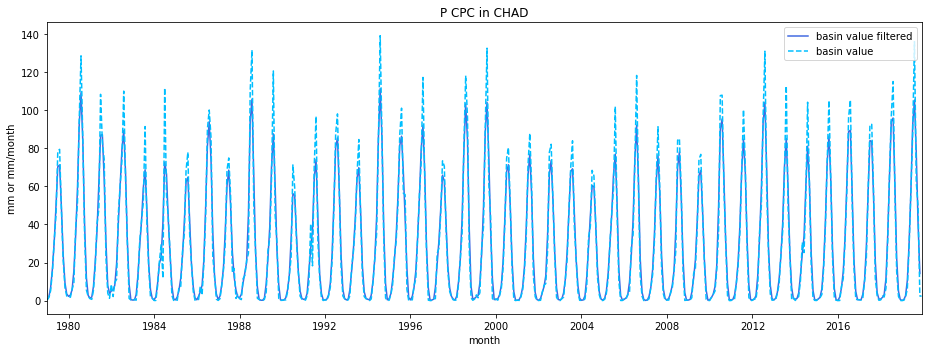

In [8]:
plt.figure(figsize=(13,5))
if hydro_var_name=='TWS': # we plot only TWS changes
    plt.plot(time_hydro[1:-1],filter_ts,label='TWSC',color='royalblue')
else:
    plt.plot(time_hydro[1:-1],filter_ts,label='basin value filtered',color='royalblue')
    plt.plot(time_hydro,mean_ts,'--',label='basin value',color='deepskyblue')
plt.legend()
plt.xlim([time_hydro.iloc[0].date(),time_hydro.iloc[-1].date()])
plt.xlabel("month")
plt.ylabel("mm or mm/month")
plt.title("{} {} in {}".format(hydro_var_name,dataset,basin_name))
plt.tight_layout()
plt.show()

# 2. Save timeseries for each basin and each dataset

In [ ]:
list_data_P=['CPC','CRU','ERA5_Land','GLDAS20','GPCC','GPCP','GPM','JRA55','MERRA2','MSWEP','TRMM']
list_data_ET=['ERA5_Land','FLUXCOM','GLEAM','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
              'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLDAS22_CLSM25','JRA55','MERRA2','MOD16','SSEBop']
list_data_R=['ERA5_Land','JRA55','GLDAS20_NOAH36','GLDAS20_CLSM25','GLDAS20_VIC412',
             'GLDAS21_NOAH36','GLDAS21_CLSM25','GLDAS21_VIC412','GLDAS22_CLSM25','GRUN','MERRA2']
list_data_TWS=['GRACE_CSR_mascons','GRACE_JPL_mascons']

In [ ]:
hydro_var_name='R'
for dataset in list_data_R:
    hydro_grid,time_hydro=get_hydro_data(hydro_var_name,dataset)
    
    # dataframe to store results
    col=[d.date() for d in time_hydro]
    df1=pd.DataFrame(np.nan*np.ones((basins.shape[0],len(col))),index=basins.index,columns=col) # weighted mean
    df2=pd.DataFrame(np.nan*np.ones((basins.shape[0],len(col)-2)),index=basins.index,columns=col[1:-1]) # filtered weighted mean
    
    pbar=ProgressBar()
    for basin_name in pbar(basins.index):
        basin_indices=geopandas.read_file("../data/basins/{}.shp".format(basin_name))
        basin_indices.set_index(pd.MultiIndex.from_frame(basin_indices[['x','y']]),inplace=True)
        hydro_grid.set_index(pd.MultiIndex.from_frame(hydro_grid[['x','y']]),inplace=True)

        # select only grid points in basin_indices
        hydro_basin=basin_indices.join(hydro_grid.loc[:,[d.date() for d in time_hydro]])
        hydro_basin.set_index(np.arange(hydro_basin.shape[0]),inplace=True)
        
        mean_ts,filter_ts=get_hydro_timeseries(hydro_basin,hydro_var_name,time_hydro,dataset)
        
        df1.loc[basin_name]=mean_ts.values
        df2.loc[basin_name]=filter_ts.values
            
    df1.to_csv('../data/hydrology_timeseries/{}_{}_monthly.csv'.format(hydro_var_name,dataset))
    df2.to_csv('../data/hydrology_timeseries/{}_{}_monthly_filtered.csv'.format(hydro_var_name,dataset))